#                                                     MLP on MNIST Dataset

In [1]:
import keras
from keras.utils import np_utils
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np
import time

Using TensorFlow backend.


# [1] Dataset Loading and pre-processing

In [2]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)


In [4]:
# for each image we have a (28*28) vector
# we will convert the (28*28) vector into single dimensional vector of 1 * 784 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

In [5]:
# after converting the input images from 3d to 2d vectors

print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d)"%(X_train.shape[1]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d)"%(X_test.shape[1]))

Number of training examples : 60000 and each image is of shape (784)
Number of training examples : 10000 and each image is of shape (784)


In [6]:
# An example data point
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [7]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)
print(X_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [8]:
# here we are having a class number for each image
print("Class label of first image :", y_train[0])

# lets convert this into a 10 dimensional vector
# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this conversion needed for MLPs 

Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

print("After converting the output into a vector : ",Y_train[0])

Class label of first image : 5
After converting the output into a vector :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# [2] MLP Models

In [9]:
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

In [10]:
# some model parameters

output_dim = 10
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 30

In [11]:
def plt_epoch_vs_loss(x, vy, ty):
    fig = plt.figure(figsize=(9,7))
    sns.set_style("whitegrid",{'axes.grid' : True})
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Categorical Crossentropy Loss")
    plt.title("Loss")
    plt.show()


## [2.1] Model 1

 Input(784) - ReLu(BatchNormalization(256)) - Dropout(0.5) - ReLu(BatchNormalization(128)) - Dropout(0.25) - Softmax(Output(10)) - Adam Optimizer

In [12]:
# for relu layers we are using 'He-Normal weight Initialization'
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(fan_in). 
# h1 =>  σ=√(2/(256) = 0.088  => N(0,σ) = N(0,0.088)
# h2 =>  σ=√(2/(128) = 0.125  => N(0,σ) = N(0,0.125)

model1 = Sequential()
model1.add(Dense(256, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.088, seed=None)))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.125, seed=None)) )
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(output_dim, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [13]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.4985 - accuracy: 0.8469 - val_loss: 0.1711 - val_accuracy: 0.9486
Epoch 2/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.2377 - accuracy: 0.9275 - val_loss: 0.1235 - val_accuracy: 0.9611
Epoch 3/30
60000/60000 [==============================] - 4s 70us/step - loss: 0.1889 - accuracy: 0.9424 - val_loss: 0.1017 - val_accuracy: 0.9688
Epoch 4/30
60000/60000 [==============================] - 4s 64us/step - loss: 0.1571 - accuracy: 0.9520 - val_loss: 0.0929 - val_accuracy: 0.9706
Epoch 5/30
60000/60000 [==============================] - 4s 66us/step - loss: 0.1395 - accuracy: 0.9567 - val_loss: 0.0855 - val_accuracy: 0.9735
Epoch 6/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.1244 - accuracy: 0.9609 - val_loss: 0.0800 - val_accuracy: 0.9733
Epoch 7/30
60000/60000 [==============================] - 5s 78us/s

Test score: 0.05358278493771504
Test accuracy: 0.9840999841690063


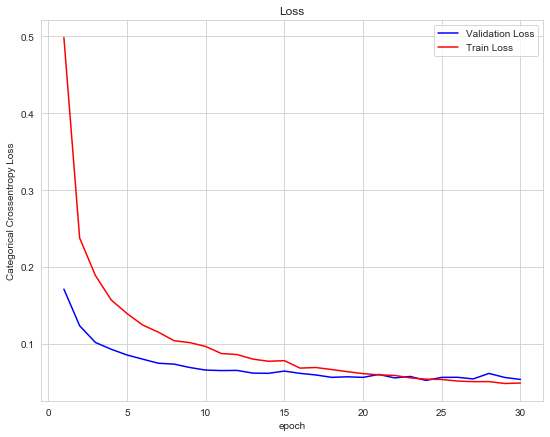

In [14]:
score1 = model1.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score1[0]) 
print('Test accuracy:', score1[1])

# list of epoch numbers
epochs = list(range(1,nb_epoch+1))
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt_epoch_vs_loss(epochs, val_loss, train_loss)

In [15]:
w_after = model1.get_weights()
print(len(w_after))

14


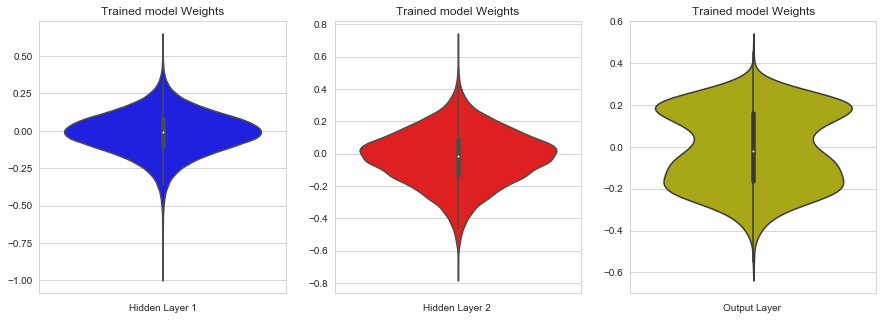

In [16]:
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[6].flatten().reshape(-1,1)
out_w = w_after[12].flatten().reshape(-1,1)


fig = plt.figure(figsize=(15,5))
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

# [2.2] Model2

Input(784) - ReLu(BatchNormalization(512)) - Dropout(0.5) - ReLu(BatchNormalization(256)) - Dropout(0.25) - ReLu(BatchNormalization(128)) - Dropout(0.125) - Softmax(Output(10)) - Adam Optimizer

In [17]:
# for relu layers we are using 'Xavier/Glorot-Normal weight Initialization'
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=2/(fan_in+fan_out). 

from keras.initializers import glorot_normal

model2 = Sequential()

model2.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=glorot_normal(seed=None)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(256, activation='relu', kernel_initializer=glorot_normal(seed=None)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(128, activation='relu', kernel_initializer=glorot_normal(seed=None)) )
model2.add(BatchNormalization())
model2.add(Dropout(0.125))

model2.add(Dense(output_dim, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [18]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 169us/step - loss: 0.3345 - accuracy: 0.8966 - val_loss: 0.1244 - val_accuracy: 0.9605
Epoch 2/30
60000/60000 [==============================] - 9s 146us/step - loss: 0.1651 - accuracy: 0.9495 - val_loss: 0.0937 - val_accuracy: 0.9716
Epoch 3/30
60000/60000 [==============================] - 9s 150us/step - loss: 0.1328 - accuracy: 0.9582 - val_loss: 0.0817 - val_accuracy: 0.9732
Epoch 4/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.1169 - accuracy: 0.9642 - val_loss: 0.0764 - val_accuracy: 0.9767
Epoch 5/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.1008 - accuracy: 0.9683 - val_loss: 0.0726 - val_accuracy: 0.9774
Epoch 6/30
60000/60000 [==============================] - 9s 144us/step - loss: 0.0927 - accuracy: 0.9708 - val_loss: 0.0662 - val_accuracy: 0.9799
Epoch 7/30
60000/60000 [==============================] - 9s 

Test score: 0.0558483196992951
Test accuracy: 0.9840999841690063


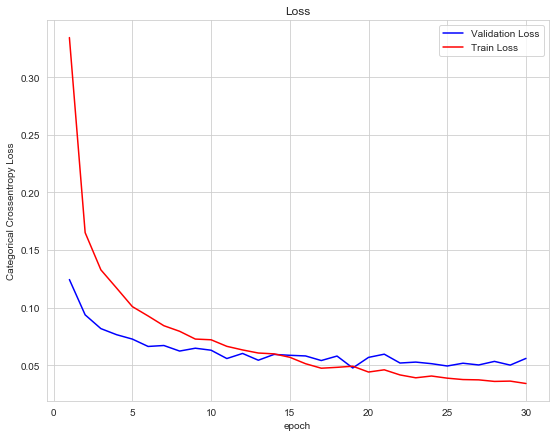

In [19]:
score2 = model2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score2[0]) 
print('Test accuracy:', score2[1])

# list of epoch numbers
epochs = list(range(1,nb_epoch+1))
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt_epoch_vs_loss(epochs, val_loss, train_loss)

In [20]:
w_after = model2.get_weights()
print(len(w_after))

20


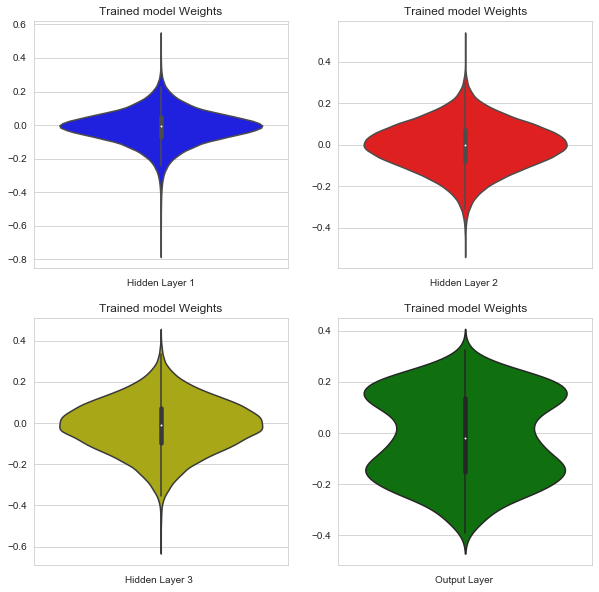

In [21]:
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[6].flatten().reshape(-1,1)
h3_w = w_after[12].flatten().reshape(-1,1)
out_w = w_after[18].flatten().reshape(-1,1)

fig = plt.figure(figsize=(10,10))
plt.title("Weight matrices after model trained")
plt.subplot(2, 2, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(2, 2, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(2, 2, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h3_w,color='y')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(2, 2, 4)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='g')
plt.xlabel('Output Layer ')
plt.show()

# [2.3] Model3

Input(784) - ReLu(BatchNormalization(512)) - Dropout(0.5) - ReLu(BatchNormalization(256)) - Dropout(0.4) - ReLu(BatchNormalization(128)) - Dropout(0.3) - ReLu(BatchNormalization(64)) - Dropout(0.2) - ReLu(BatchNormalization(32)) - Dropout(0.1) - Softmax(Output(10)) - Adam Optimizer

In [22]:
# for relu layers we are using 'He-Normal weight Initialization'
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=2/(fan_in+fan_out). 

from keras.initializers import he_normal

model3 = Sequential()

model3.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=he_normal(seed=None)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(256, activation='relu', kernel_initializer=he_normal(seed=None)))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Dense(128, activation='relu', kernel_initializer=he_normal(seed=None)) )
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(64, activation='relu', kernel_initializer=he_normal(seed=None)) )
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Dense(32, activation='relu', kernel_initializer=he_normal(seed=None)) )
model3.add(BatchNormalization())
model3.add(Dropout(0.1))

model3.add(Dense(output_dim, activation='softmax'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [23]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 12s 194us/step - loss: 0.6755 - accuracy: 0.7921 - val_loss: 0.1842 - val_accuracy: 0.9442
Epoch 2/30
60000/60000 [==============================] - 10s 168us/step - loss: 0.2663 - accuracy: 0.9239 - val_loss: 0.1292 - val_accuracy: 0.9639
Epoch 3/30
60000/60000 [==============================] - 10s 166us/step - loss: 0.2076 - accuracy: 0.9409 - val_loss: 0.1088 - val_accuracy: 0.9686
Epoch 4/30
60000/60000 [==============================] - 10s 167us/step - loss: 0.1793 - accuracy: 0.9498 - val_loss: 0.0968 - val_accuracy: 0.9723
Epoch 5/30
60000/60000 [==============================] - 11s 175us/step - loss: 0.1575 - accuracy: 0.9552 - val_loss: 0.0918 - val_accuracy: 0.9719
Epoch 6/30
60000/60000 [==============================] - 10s 167us/step - loss: 0.1455 - accuracy: 0.9595 - val_loss: 0.0854 - val_accuracy: 0.9745
Epoch 7/30
60000/60000 [==============================] 

Test score: 0.053111556177656165
Test accuracy: 0.98580002784729


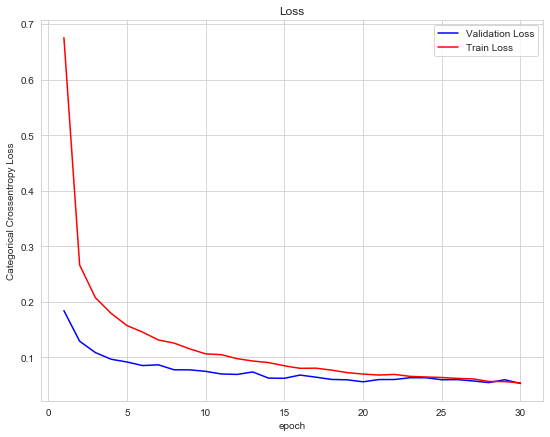

In [24]:
score3 = model3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score3[0]) 
print('Test accuracy:', score3[1])

# list of epoch numbers
epoch = list(range(1,nb_epoch+1))
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt_epoch_vs_loss(epoch, val_loss, train_loss)

In [25]:
w_after = model3.get_weights()
print(len(w_after))

32


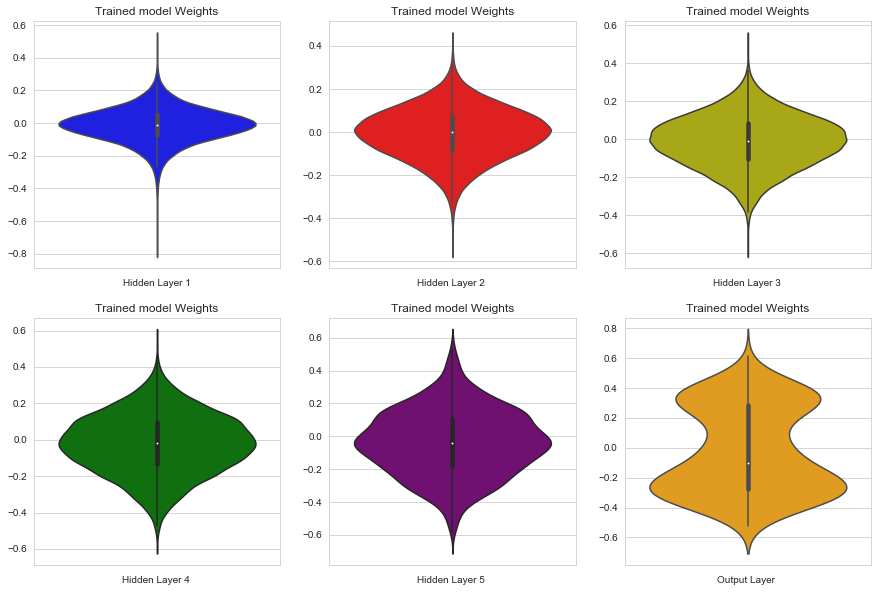

In [26]:
h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[6].flatten().reshape(-1,1)
h3_w = w_after[12].flatten().reshape(-1,1)
h4_w = w_after[18].flatten().reshape(-1,1)
h5_w = w_after[24].flatten().reshape(-1,1)
out_w = w_after[30].flatten().reshape(-1,1)

fig = plt.figure(figsize=(15,10))
plt.title("Weight matrices after model trained")
plt.subplot(2, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(2, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(2, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h3_w,color='y')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(2, 3, 4)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h4_w,color='g')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(2, 3, 5)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h5_w,color='purple')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(2, 3, 6)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='orange')
plt.xlabel('Output Layer ')
plt.show()

# [3] Results

In [27]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model","Hidden Layers","Score","Accuracy"]
table.add_row([1,2,round(score1[0],3),round(score1[1],3)])
table.add_row([2,3,round(score2[0],3),round(score2[1],3)])
table.add_row([3,5,round(score3[0],3),round(score3[1],3)])

print(table.get_string(title="Results"))

+------------------------------------------+
|                 Results                  |
+-------+---------------+-------+----------+
| Model | Hidden Layers | Score | Accuracy |
+-------+---------------+-------+----------+
|   1   |       2       | 0.054 |  0.984   |
|   2   |       3       | 0.056 |  0.984   |
|   3   |       5       | 0.053 |  0.986   |
+-------+---------------+-------+----------+


# [4] Conclusion

There is no much difference in the accuracy of all models.